# JPEG Concepts Part 1
# Quantizing Discrete Cosine Transform Coefficients
## Chris Tralie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import skimage

## An Audio Analogy

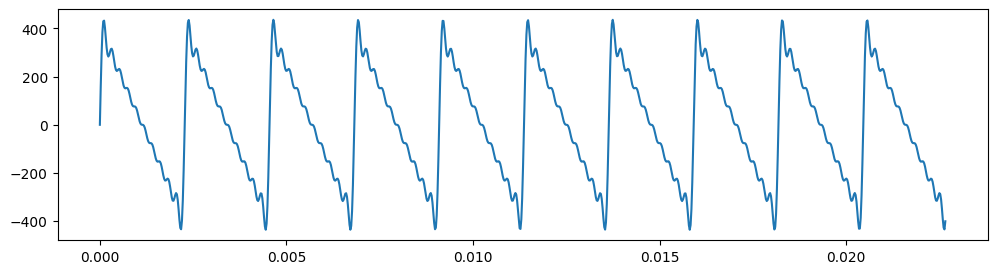

In [2]:
sr = 44100
t = np.arange(sr*2)/sr
## Sawtooth wave
## sin(2pi * f t) + sin(2pi * 2f * t) / 2 + sin(2 pi * 3f * t) / 3 + ...
f = 440
n_sines = 10
amps = 255 / np.arange(1, n_sines+1)
y = np.zeros(t.size)
for i, a in enumerate(amps):
    y += np.sin(2*np.pi*f*(i+1)*t)*a
plt.figure(figsize=(12, 3))
plt.plot(t[0:1000], y[0:1000])
ipd.Audio(y, rate=sr)

[ 1  2  3  4  5  6  7  8  9 10]
[[255.         127.5         85.          63.75        51.
   42.5         36.42857143  31.875       28.33333333  25.5       ]
 [255.         128.          84.          64.          50.
   42.          35.          32.          27.          30.        ]]


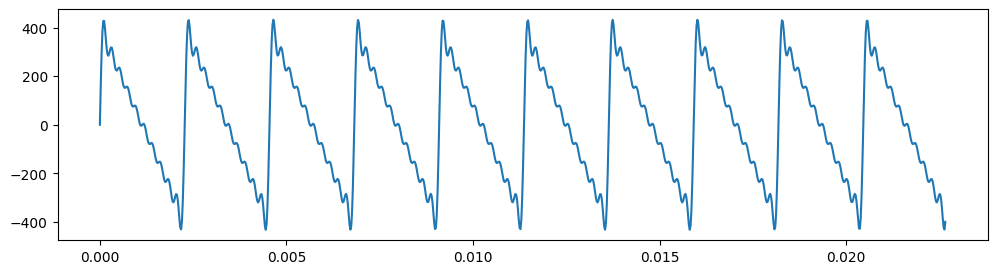

In [3]:
q = np.arange(1, n_sines+1)
print(q)

amps_rounded = q*np.round(amps/q)
a = np.array([amps, amps_rounded])
print(a)

y = np.zeros(t.size)
for i, a in enumerate(amps_rounded):
    y += np.sin(2*np.pi*f*(i+1)*t)*a
plt.figure(figsize=(12, 3))
plt.plot(t[0:1000], y[0:1000])
ipd.Audio(y, rate=sr)

[  1   4   9  16  25  36  49  64  81 100]
[[255.         127.5         85.          63.75        51.
   42.5         36.42857143  31.875       28.33333333  25.5       ]
 [255.         128.          81.          64.          50.
   36.          49.           0.           0.           0.        ]]


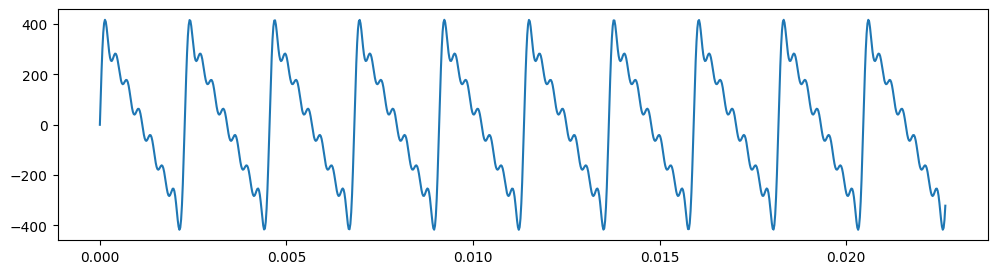

In [4]:
q = np.arange(1, n_sines+1)**2
print(q)

amps_rounded = q*np.round(amps/q)
a = np.array([amps, amps_rounded])
print(a)

y = np.zeros(t.size)
for i, a in enumerate(amps_rounded):
    y += np.sin(2*np.pi*f*(i+1)*t)*a
plt.figure(figsize=(12, 3))
plt.plot(t[0:1000], y[0:1000])
ipd.Audio(y, rate=sr)

## YCbCr Image Encoding / Blocking

In [5]:
I = skimage.io.imread("Mandrill_Albert_September_2015_Zoo_Berlin.png")
b = 8
I = I[0:b*(I.shape[0]//b), 0:b*(I.shape[1]//b), :]
R = I[:, :, 0]
G = I[:, :, 1]
B = I[:, :, 2]

# Y (Illuminance/Grayscale/Brightness)
# Cb (Chroma blue)
# Cr (Chroma red)

IYCbCr = np.zeros(I.shape, dtype=float)
IYCbCr[:, :, 0] = 0.299*R + 0.587*G + 0.114*B # Y
IYCbCr[:, :, 1] = -0.1687*R - 0.3313*G + 0.5*B + 128 #Cb
IYCbCr[:, :, 2] = 0.5*R - 0.4187*G - 0.0813*B + 128 #Cr

IYBlock = skimage.util.view_as_blocks(IYCbCr[:, :, 0], (b, b))
print(IYCbCr[:, :, 0].shape)
print(IYBlock.shape)

(1304, 1000)
(163, 125, 8, 8)


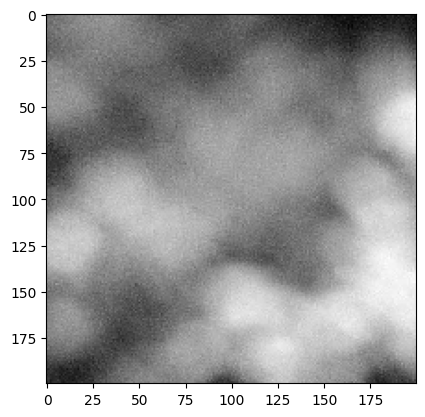

In [6]:
plt.imshow(IYCbCr[0:200, 0:200, 0], cmap='gray')

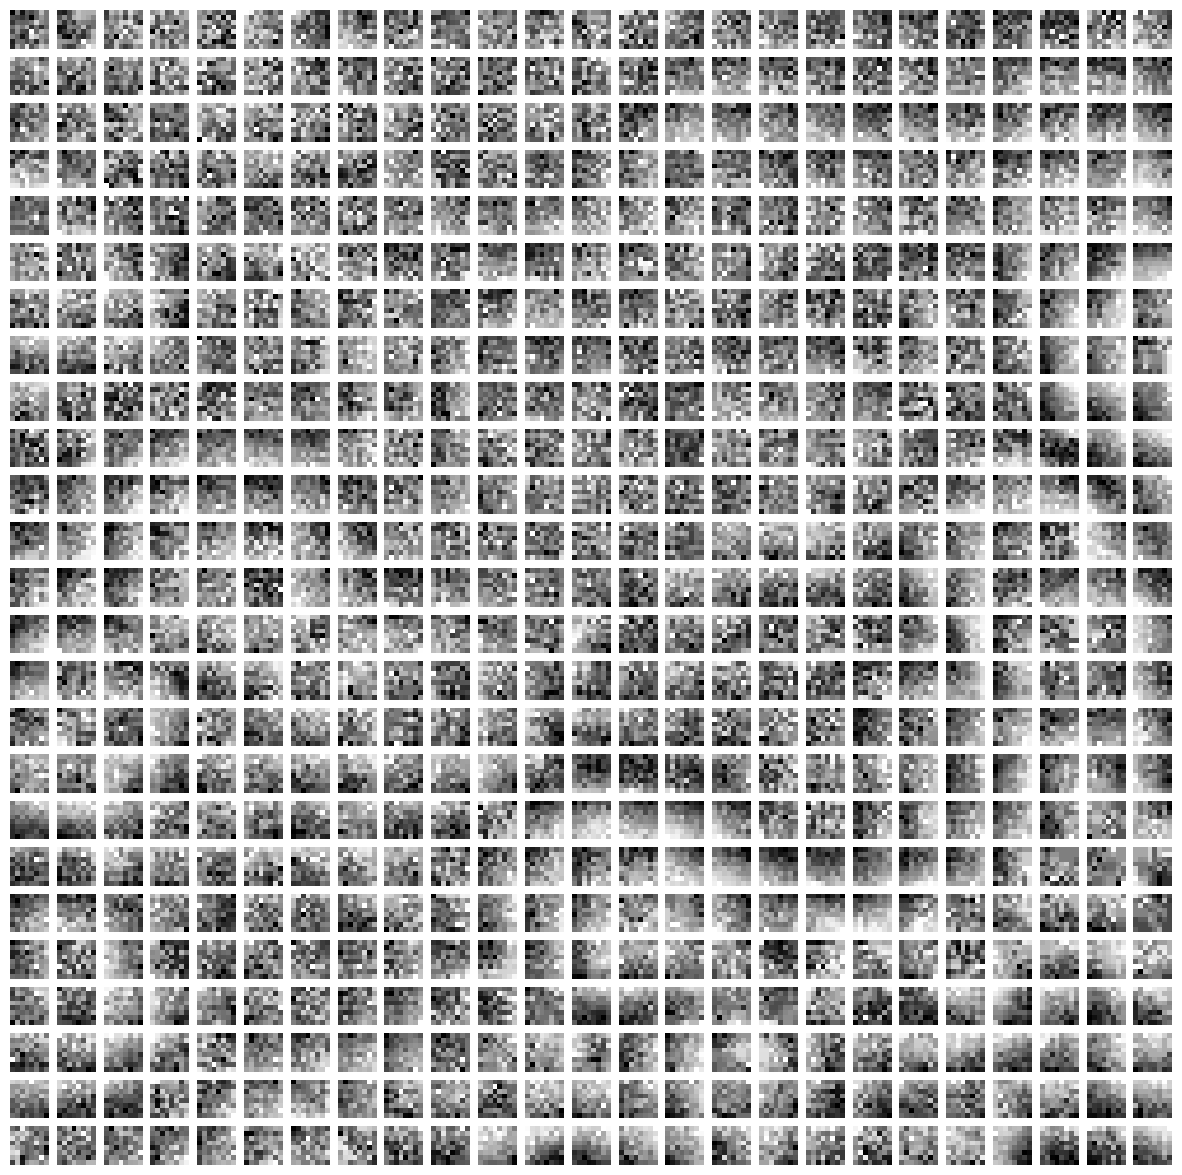

In [7]:
plt.figure(figsize=(15, 15))

k = 1
for i in range(25):
    for j in range(25):
        plt.subplot(25, 25, k)
        plt.imshow(IYBlock[i, j, :, :], cmap='gray')
        plt.axis("off")
        k += 1

## DCT Coefficients

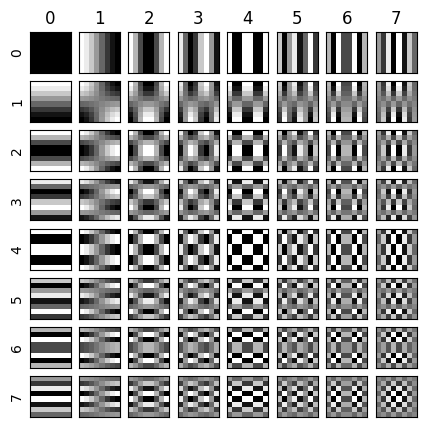

In [8]:
pix = np.arange(b)
I, J = np.meshgrid(pix, pix, indexing='ij')
# Roughly number of cycles that a cosine completes over ~2 blocks
plt.figure(figsize=(5, 5))
k = 1
for u in range(b):
    for v in range(b):
        Osc2D = (2/b)*np.cos((2*I+1)*u*np.pi/(2*b)) * np.cos((2*J+1)*v*np.pi/(2*b))
        plt.subplot(b, b, k)
        plt.imshow(Osc2D, interpolation='none', cmap='gray')
        if u == 0:
            Osc2D *= 1/np.sqrt(2)
            plt.title(f"{v}")
        if v == 0:
            Osc2D *= 1/np.sqrt(2)
            plt.ylabel(f"{u}")
        
        plt.xticks([])
        plt.yticks([])
        k += 1

### Constructing DCT Basis in Zig-Zag Order

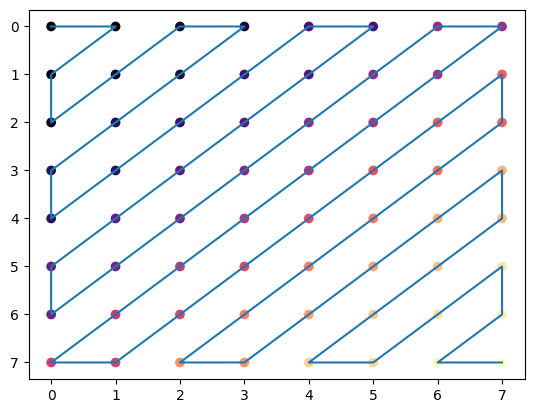

In [9]:
def get_zigzag_order(N):
    istart, jstart = 0, 0
    order = []
    for d in range(2*N-1): # 2*N -1 Diagonals
        # Loop through diagonal
        i = istart
        j = jstart
        diag = []
        while i >= 0 and j < N:
            diag.append([i, j])
            i -= 1
            j += 1
        if d%2 == 1:
            diag = reversed(diag)
        order += diag
        if istart == N-1:
            jstart += 1
        else:
            istart += 1
    return order
order = get_zigzag_order(8)
order = np.array(order)
plt.scatter(order[:, 1], order[:, 0], c=np.arange(order.shape[0]), cmap='magma')
plt.plot(order[:, 1], order[:, 0])
plt.gca().invert_yaxis()

In [10]:
basis = np.zeros((b*b, b, b))

pix = np.arange(b)
I, J = np.meshgrid(pix, pix, indexing='ij')
for i, [u, v] in enumerate(get_zigzag_order(b)):
    Osc2D = (2/b)*np.cos((2*I+1)*u*np.pi/(2*b)) * np.cos((2*J+1)*v*np.pi/(2*b))
    if u == 0:
        Osc2D *= 1/np.sqrt(2)
    if v == 0:
        Osc2D *= 1/np.sqrt(2)
    basis[i, :, :] = Osc2D

print(np.sum(np.sum(basis**2, axis=2), axis=1))
## 1) The sum of the squares of each pixel in a pattern is 1
## 2) The dot product of each pair of basis elements is 0
print(np.sum(basis[5, :, :]*basis[22, :, :]))

## This is called an "orthogonal basis" for patterns over 8x8 blocks

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
3.469446951953614e-18


### DCT Projection Example

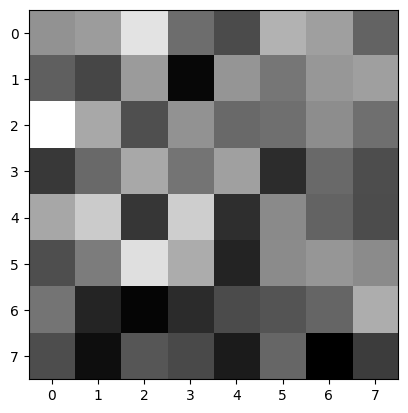

In [11]:
patch = IYBlock[15, 15, :, :]
plt.imshow(patch, interpolation='none', cmap='gray')

In [ ]:
mn = np.min(patch)
mx = np.max(patch)
rg = mx-mn
patch_proj = np.zeros_like(patch)
plt.figure(figsize=(10, 10))
for i in range(b*b):
    proji = basis[i, :, :]*np.sum(basis[i, :, :]*patch)
    patch_proj += proji
    
    plt.clf()
    plt.subplot(221)
    plt.scatter(order[:, 1], order[:, 0], c=np.arange(order.shape[0]), cmap='magma')
    plt.plot(order[:, 1], order[:, 0])
    plt.scatter(order[i, 1], order[i, 0], s=100, c='r')
    plt.gca().invert_yaxis()
    plt.title("Basis Element")
    plt.subplot(222)
    plt.imshow(patch, cmap='gray', interpolation='none', vmin=mn, vmax=mx)
    plt.title("Target Image")
    plt.subplot(223)
    plt.imshow(proji, cmap='gray', interpolation='none', vmin=-rg/2, vmax=rg/2)
    plt.title("Basis Element")
    plt.subplot(224)
    plt.imshow(patch_proj, cmap='gray', interpolation='none', vmin=mn, vmax=mx)
    plt.title("Approximation")
    plt.savefig(f"proj{i}.png")

<img src = "ProjExample.gif">

### Extracting Quantization Tables from Real Files

In [12]:
def get_Q(s):
    return np.array([int(x, 16) for x in s.split()])

q_med = "10 0B 0C 0E 0C 0A 10 0E 0D 0E 12 11 10 13 18 28 1A 18 16 16 18 31 23 25 1D 28 3A 33 3D 3C 39 33 38 37 40 48 5C 4E 40 44 57 45 37 38 50 6D 51 57 5F 62 67 68 67 3E 4D 71 79 70 64 78 5C 65 67 63"
q_med = get_Q(q_med)
q_low = "50 37 3C 46 3C 32 50 46 41 46 5A 55 50 5F 78 C8 82 78 6E 6E 78 F5 AF B9 91 C8 FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF"
q_low = get_Q(q_low)
print(q_med)
print(q_low)

[ 16  11  12  14  12  10  16  14  13  14  18  17  16  19  24  40  26  24
  22  22  24  49  35  37  29  40  58  51  61  60  57  51  56  55  64  72
  92  78  64  68  87  69  55  56  80 109  81  87  95  98 103 104 103  62
  77 113 121 112 100 120  92 101 103  99]
[ 80  55  60  70  60  50  80  70  65  70  90  85  80  95 120 200 130 120
 110 110 120 245 175 185 145 200 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255]


### Performing Projection/Quantization with Matrices

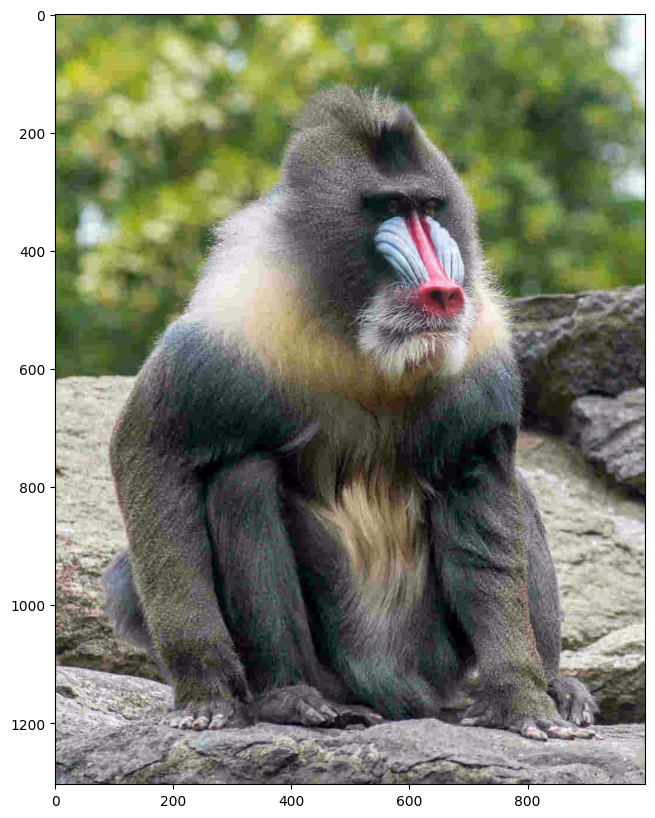

In [16]:
basis = np.reshape(basis, (b*b, b*b))
q = np.array(q_low)
q = q[None, :]

res = np.zeros_like(IYCbCr)
## For each channel
for ch in range(3):
    img_shape = IYCbCr[:, :, ch].shape
    Bs = skimage.util.view_as_blocks(IYCbCr[:, :, ch], (b, b))
    ## For each block b in channel
    ##   Project b onto each basis element in DCT
    blocks_shape_orig = Bs.shape
    Bs = np.reshape(Bs, (Bs.shape[0]*Bs.shape[1], b*b))
    proj = Bs.dot(basis.T)
    ## Quantize each projection according to quantization table
    proj = q*np.round(proj/q)
    ## Add back the projection coefficients multiplied by the DCT patterns
    Bs = proj.dot(basis)
    ## Reshape and unravel back into an image
    Bs = np.reshape(Bs, blocks_shape_orig)
    Bs = np.moveaxis(Bs, [0, 1, 2, 3], [0, 2, 1, 3])
    Bs = np.reshape(Bs, img_shape)
    res[:, :, ch] = Bs

## Convert back to RGB from YCbCr
Y  = res[:, :, 0]
Cb = res[:, :, 1]
Cr = res[:, :, 2]

res = np.array(res) # Make a new array to hold the result
res[:, :, 0] = Y + 1.402*(Cr - 128)
res[:, :, 1] = Y - 0.34414*(Cb - 128) - 0.71414*(Cr - 128)
res[:, :, 2] = Y + 1.772*(Cb - 128)
res[res < 0] = 0
res[res > 255] = 255
res = np.array(res, dtype=np.uint8)
plt.figure(figsize =(15, 10))
plt.imshow(res)